In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

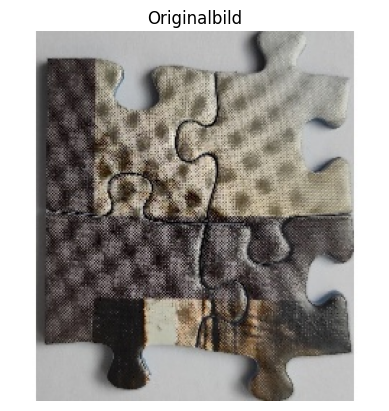

In [30]:
# Beispielbild laden
image_path = "../data/pzl_1_processed/pzl_1_full_front.jpg"  # Neuer Pfad zum Gesamtpuzzle
image = cv2.imread(image_path)
if image is None:
    print(f"Fehler beim Laden des Bildes: {image_path}")
else:
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Originalbild")
    plt.axis("off")
    plt.show()

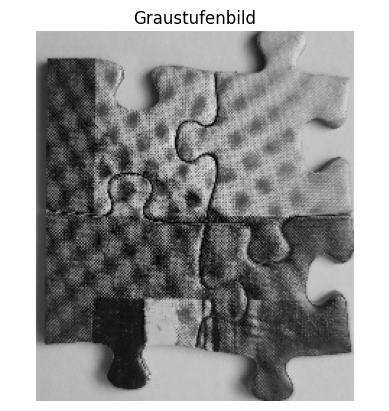

In [31]:
## Wandle das Bild in Graustufen um ohne die OpenCV-Funktion cvtColor zu verwenden
gray_image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])
# Konvertiere das Graustufenbild in uint8
gray_image = np.clip(gray_image, 0, 255).astype(np.uint8)
# Zeige das Graustufenbild an
plt.imshow(gray_image, cmap='gray')
plt.title("Graustufenbild")
plt.axis("off")
plt.show()

### Kantenerkennung mithilfe vom Sobel-Operator

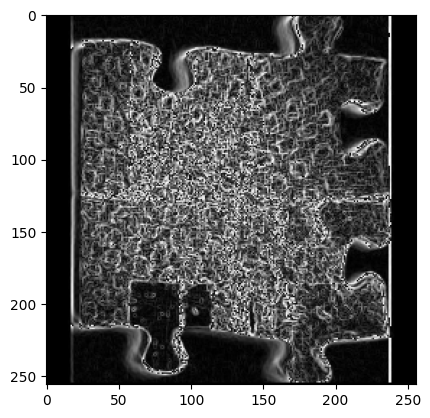

In [32]:
#Erkenne mithilfe vom Sobel-Operator 
#Kanten im Graustufenbild 
#ohne die OpenCV-Funktion Sobel zu verwenden

def sobel_operator(image):
    # Sobel-Kernel für x- und y-Richtung
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    
    sobel_y = np.array([[1, 2, 1],
                        [0, 0, 0],
                        [-1,-2,-1]])
    
    # Initialisiere das Ergebnisbild
    gradient_magnitude = np.zeros_like(image)

    # Wende den Sobel-Operator an
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            gx = np.sum(sobel_x * image[i-1:i+2, j-1:j+2])
            gy = np.sum(sobel_y * image[i-1:i+2, j-1:j+2])
            gradient_magnitude[i, j] = np.sqrt(gx**2 + gy**2)
    
    return gradient_magnitude
# Wende den Sobel-Operator auf das Graustufenbild an
edges = sobel_operator(gray_image)
# Normalisiere die Kantenstärke auf den Bereich [0, 255]
edges = np.clip(edges, 0, 255).astype(np.uint8)
# Zeige das Ergebnis an
plt.imshow(edges, cmap='gray')

### Kantenerkennung mithilfe von Canny-Kantendetektion

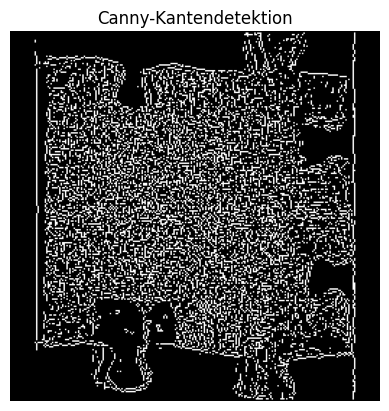

In [33]:
# Kantenerkennung mithilfe von Canny-Kantendetektion ohne die OpenCV-Funktion Canny zu verwenden
def canny_edge_detection(image, low_threshold, high_threshold):
    # Wende den Sobel-Operator an
    gradient_magnitude = sobel_operator(image)
    
    # Non-maximum Suppression
    suppressed = np.zeros_like(gradient_magnitude)
    angle = np.arctan2(np.gradient(image, axis=0), np.gradient(image, axis=1)) * 180 / np.pi
    angle[angle < 0] += 180
    
    for i in range(1, gradient_magnitude.shape[0] - 1):
        for j in range(1, gradient_magnitude.shape[1] - 1):
            q = 255
            r = 255
            
            # Winkel anpassen
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                q = gradient_magnitude[i, j + 1]
                r = gradient_magnitude[i, j - 1]
            elif (22.5 <= angle[i, j] < 67.5):
                q = gradient_magnitude[i + 1, j - 1]
                r = gradient_magnitude[i - 1, j + 1]
            elif (67.5 <= angle[i, j] < 112.5):
                q = gradient_magnitude[i + 1, j]
                r = gradient_magnitude[i - 1, j]
            elif (112.5 <= angle[i, j] < 157.5):
                q = gradient_magnitude[i - 1, j - 1]
                r = gradient_magnitude[i + 1, j + 1]

            if (gradient_magnitude[i, j] >= q) and (gradient_magnitude[i, j] >= r):
                suppressed[i, j] = gradient_magnitude[i, j]
            else:
                suppressed[i, j] = 0

    # Double Thresholding
    strong_edges = (suppressed >= high_threshold)
    weak_edges = ((suppressed >= low_threshold) & (suppressed < high_threshold))
    
    # Edge Tracking by Hysteresis
    edges_final = np.zeros_like(suppressed)
    edges_final[strong_edges] = 255
    
    for i in range(1, suppressed.shape[0] - 1):
        if weak_edges[i, j]:
            if ((strong_edges[i + 1, j - 1] or strong_edges[i + 1, j] or strong_edges[i + 1, j + 1]) or
                (strong_edges[i, j - 1] or strong_edges[i, j + 1]) or
                (strong_edges[i - 1, j - 1] or strong_edges[i - 1, j] or strong_edges[i - 1, j + 1])):
                edges_final[i, j] = 255
    return edges_final
# Wende die Canny-Kantendetektion an
#high_treshold = 65 bei einzelnem Puzzle

edges_canny = canny_edge_detection(gray_image, low_threshold=100, high_threshold=65)
# Zeige das Ergebnis der Canny-Kantendetektion an
plt.imshow(edges_canny, cmap='gray')
plt.title("Canny-Kantendetektion")
plt.axis("off")
plt.show()

Anzahl der gefundenen Puzzlestücke: 5


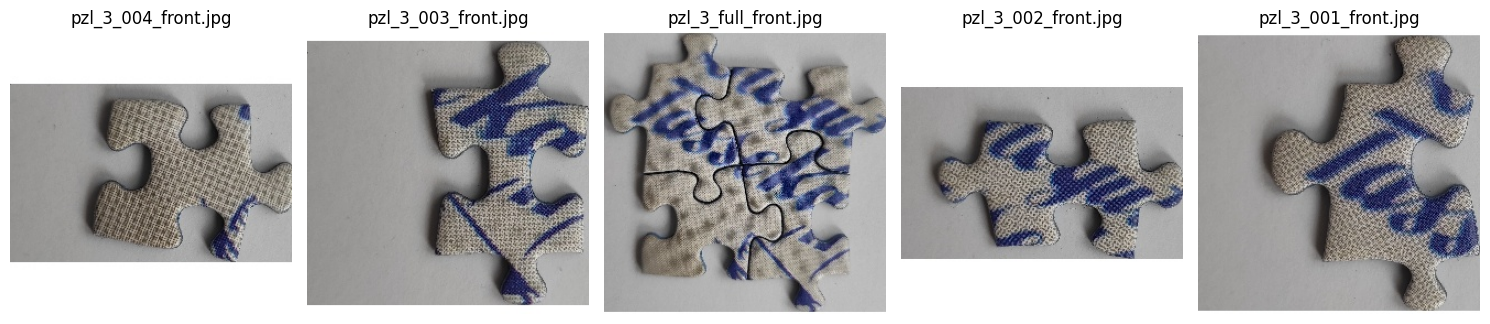

In [34]:
#Lade alle einzelen Puzzlestuecke aus dem Verzeichnis welche mit front enden
puzzle_dir = Path("../data/pzl_3_processed/")
puzzle_images = list(puzzle_dir.glob("*_front.jpg"))
if not puzzle_images:
    print("Keine Puzzlestücke gefunden.")
else:
    # Zeige die Anzahl der gefundenen Puzzlestücke an
    print(f"Anzahl der gefundenen Puzzlestücke: {len(puzzle_images)}")
    
    # Zeige die ersten 5 Puzzlestücke nebeneinander an
    fig, axes = plt.subplots(1, min(5, len(puzzle_images)), figsize=(15, 5))
    for ax, puzzle_image in zip(axes, puzzle_images[:5]):
        img = cv2.imread(str(puzzle_image))
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(puzzle_image.name)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


Canny-Kantenerkennung gespeichert: ../data/pzl_3_processed/canny_images/pzl_3_004_front_canny.jpg


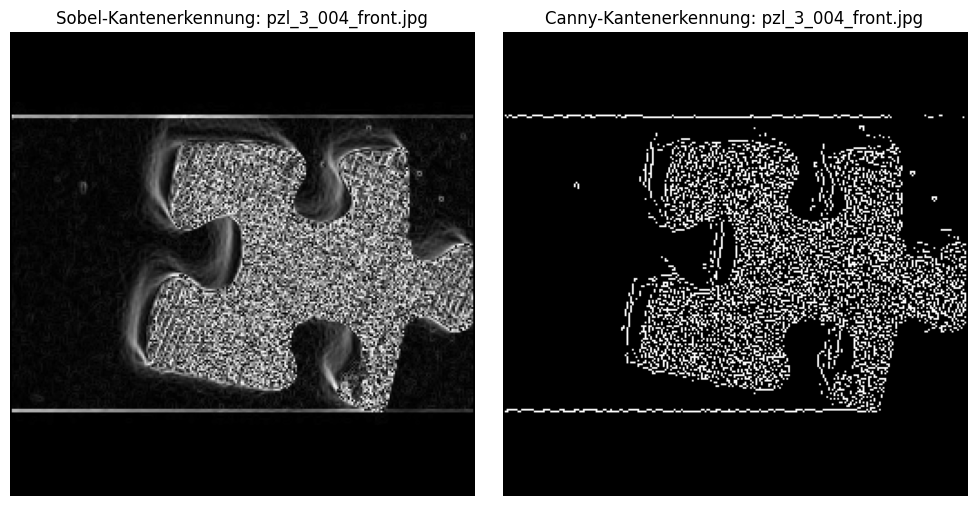

Canny-Kantenerkennung gespeichert: ../data/pzl_3_processed/canny_images/pzl_3_003_front_canny.jpg


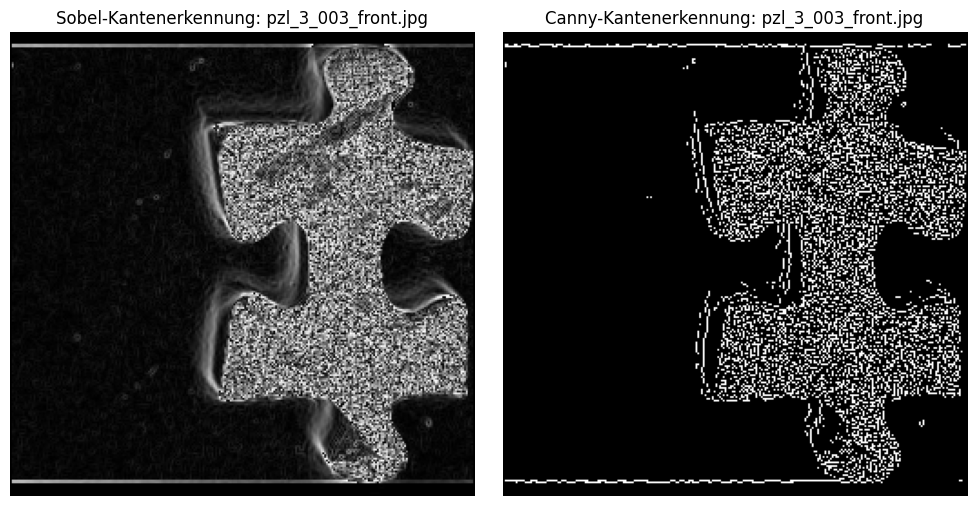

Canny-Kantenerkennung gespeichert: ../data/pzl_3_processed/canny_images/pzl_3_full_front_canny.jpg


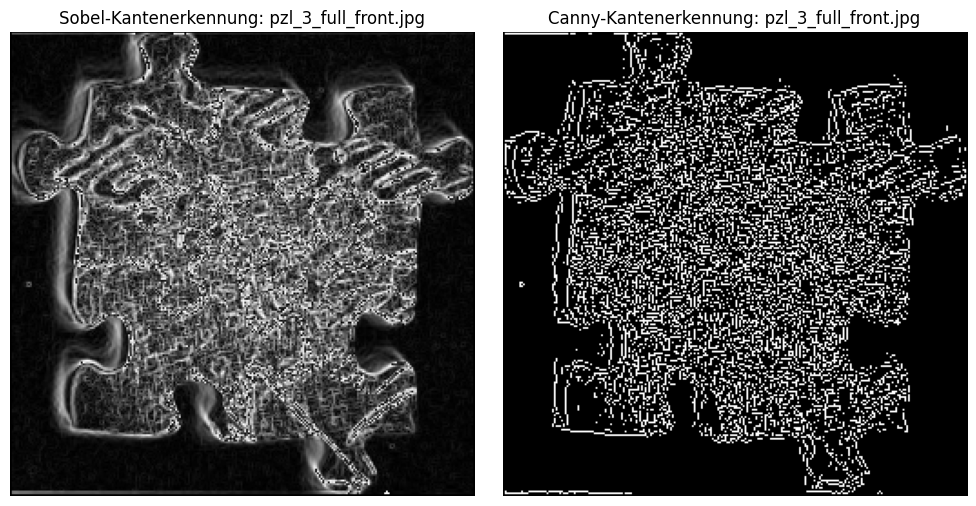

Canny-Kantenerkennung gespeichert: ../data/pzl_3_processed/canny_images/pzl_3_002_front_canny.jpg


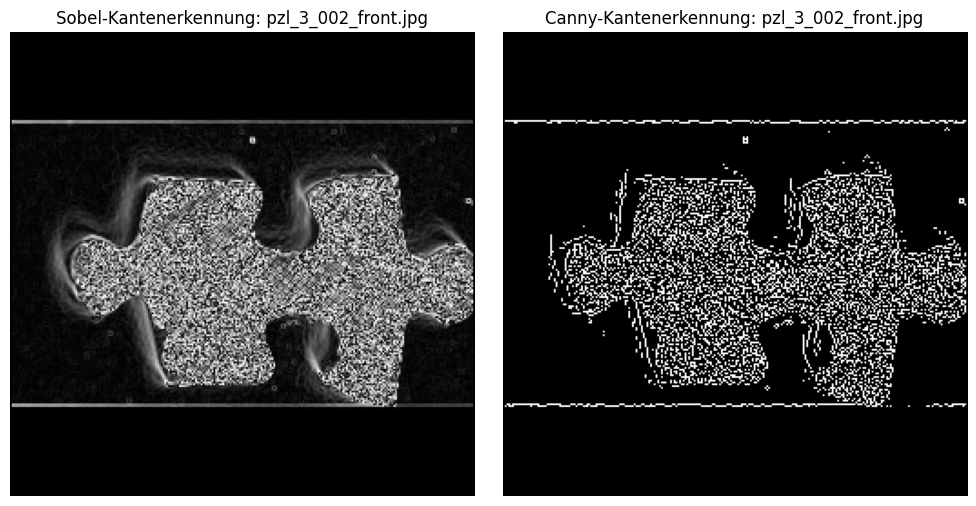

Canny-Kantenerkennung gespeichert: ../data/pzl_3_processed/canny_images/pzl_3_001_front_canny.jpg


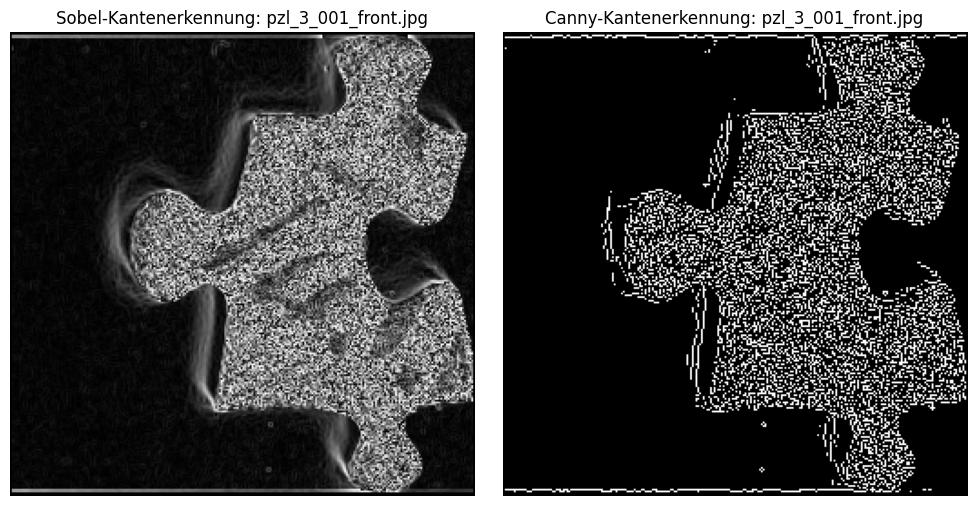

In [35]:
# Erstelle den Zielordner für die Canny-Bilder
output_dir = Path("../data/pzl_3_processed/canny_images/")
output_dir.mkdir(parents=True, exist_ok=True)

# Wende Canny und Sobel auf jedes Puzzlestück an und speichere die Ergebnisse
for puzzle_image in puzzle_images:
    img = cv2.imread(str(puzzle_image))
    if img is None:
        print(f"Fehler beim Laden des Bildes: {puzzle_image}")
        continue

    # Konvertiere das Bild in Graustufen
    gray_img = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])
    gray_img = np.clip(gray_img, 0, 255).astype(np.uint8)

    # Wende Sobel- und Canny-Kantendetektion an
    edges_sobel = sobel_operator(gray_img)
    edges_sobel = np.clip(edges_sobel, 0, 255).astype(np.uint8)

    edges_canny = canny_edge_detection(gray_img, low_threshold=100, high_threshold=65)

    # Speichere die Canny-Kantendetektionsergebnisse im Zielordner
    output_file = output_dir / f"{puzzle_image.stem}_canny.jpg"
    cv2.imwrite(str(output_file), edges_canny)

    print(f"Canny-Kantenerkennung gespeichert: {output_file}")

    # Zeige die Ergebnisse an
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(edges_sobel, cmap='gray')
    plt.title(f"Sobel-Kantenerkennung: {puzzle_image.name}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(edges_canny, cmap='gray')
    plt.title(f"Canny-Kantenerkennung: {puzzle_image.name}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

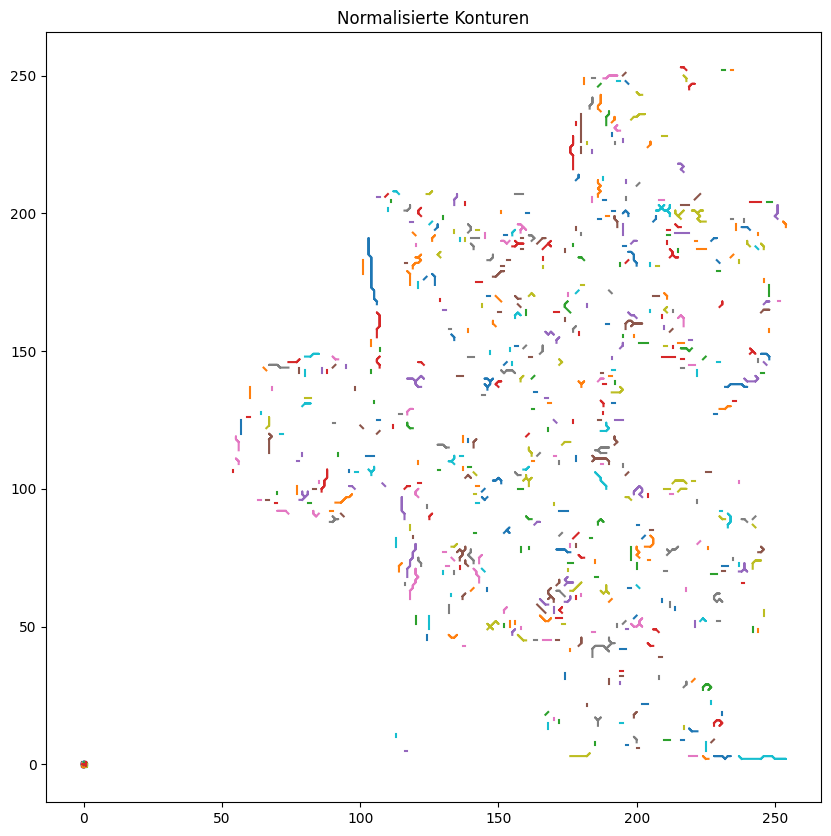

In [36]:
def normalize_contour(contour):
    """
    Normalisiert eine Kontur, indem sie skaliert, rotiert und verschoben wird,
    sodass sie vergleichbar wird.
    """
    # Berechne den Schwerpunkt der Kontur
    moments = cv2.moments(contour)
    if moments["m00"] == 0:
        return contour  # Vermeide Division durch Null
    cx = int(moments["m10"] / moments["m00"])
    cy = int(moments["m01"] / moments["m00"])

    # Verschiebe die Kontur so, dass der Schwerpunkt im Ursprung liegt
    shifted_contour = contour - [cx, cy]

    # Berechne die minimale umschließende Box
    rect = cv2.minAreaRect(shifted_contour)
    angle = rect[-1]

    # Rotationswinkel anpassen
    if angle < -45:
        angle += 90

    # Rotationsmatrix erstellen
    rotation_matrix = cv2.getRotationMatrix2D((0, 0), angle, 1.0)

    # Rotierte Kontur berechnen
    rotated_contour = cv2.transform(shifted_contour, rotation_matrix)

    # Berechne die Skalierung, um die Kontur auf eine einheitliche Größe zu bringen
    _, (width, height), _ = rect
    scale_factor = 1.0 / max(width, height)

    # Skaliere die Kontur
    normalized_contour = rotated_contour * scale_factor

    return normalized_contour

# Beispiel: Normalisiere eine Kontur aus einem binären Bild
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
normalized_contours = [normalize_contour(contour) for contour in contours]

# Visualisiere die normalisierten Konturen
plt.figure(figsize=(10, 10))
for contour in normalized_contours:
    plt.plot(contour[:, 0, 0], contour[:, 0, 1])
plt.title("Normalisierte Konturen")
plt.axis("equal")
plt.show()

Match-Score für pzl_3_004_front.jpg: 0.04190618903407084
Puzzleteil pzl_3_004_front.jpg passt zum Referenzbild.


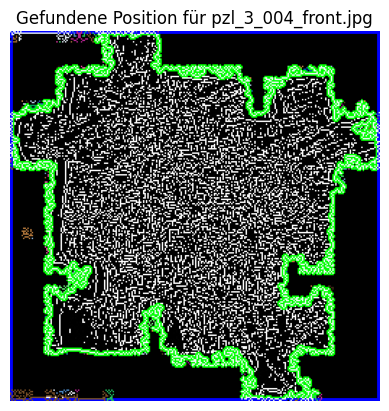

Match-Score für pzl_3_003_front.jpg: 0.04190618903407084
Puzzleteil pzl_3_003_front.jpg passt zum Referenzbild.


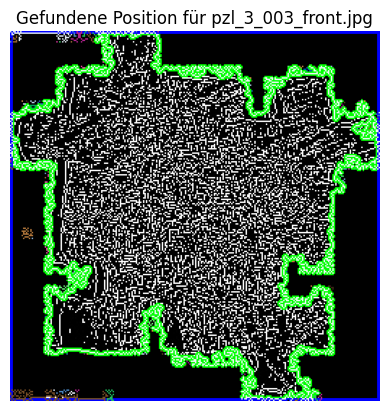

Match-Score für pzl_3_full_front.jpg: 0.04190618903407084
Puzzleteil pzl_3_full_front.jpg passt zum Referenzbild.


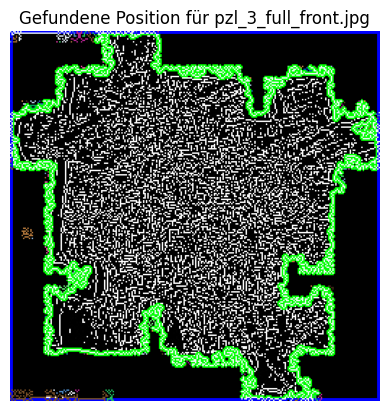

Match-Score für pzl_3_002_front.jpg: 0.04190618903407084
Puzzleteil pzl_3_002_front.jpg passt zum Referenzbild.


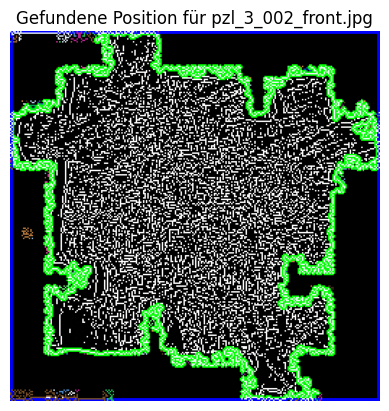

Match-Score für pzl_3_001_front.jpg: 0.04190618903407084
Puzzleteil pzl_3_001_front.jpg passt zum Referenzbild.


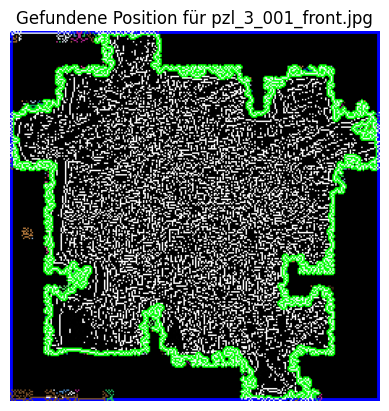

In [37]:
# Filtere nur die Bilder, die mit "_front" enden
front_puzzle_images = [img for img in puzzle_images if "_front" in img.name]

# Lade das Referenzbild (pzl_3_full_front_canny.jpg)
reference_image_path = "../data/pzl_3_processed/canny_images/pzl_3_full_front_canny.jpg"
reference_image = cv2.imread(reference_image_path, cv2.IMREAD_GRAYSCALE)

if reference_image is None:
    print(f"Fehler beim Laden des Referenzbildes: {reference_image_path}")
else:
    # Finde Konturen im Referenzbild
    ref_contours, _ = cv2.findContours(reference_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Überprüfe, ob Konturen gefunden wurden
    if not ref_contours:
        print("Keine Konturen im Referenzbild gefunden.")
    else:
        # Nimm die größte Kontur im Referenzbild an
        ref_contour = max(ref_contours, key=cv2.contourArea)

        # Iteriere über alle gefilterten Puzzleteile
        for puzzle_image_path in front_puzzle_images:
            puzzle_image = cv2.imread(str(puzzle_image_path), cv2.IMREAD_GRAYSCALE)

            if puzzle_image is None:
                print(f"Fehler beim Laden des Puzzleteils: {puzzle_image_path}")
                continue

            # Finde Konturen im Puzzleteil
            puzzle_contours, _ = cv2.findContours(puzzle_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Überprüfe, ob Konturen gefunden wurden
            if not puzzle_contours:
                print(f"Keine Konturen im Puzzleteil gefunden: {puzzle_image_path}")
                continue

            # Nimm die größte Kontur im Puzzleteil an
            puzzle_contour = max(puzzle_contours, key=cv2.contourArea)

            # Vergleiche die Konturen mit cv2.matchShapes
            match_score = cv2.matchShapes(ref_contour, puzzle_contour, cv2.CONTOURS_MATCH_I1, 0.0)

            print(f"Match-Score für {puzzle_image_path.name}: {match_score}")

            # Wenn der Match-Score unter einem bestimmten Schwellenwert liegt, markiere die Position
            if match_score < 0.1:  # Schwellenwert anpassen
                print(f"Puzzleteil {puzzle_image_path.name} passt zum Referenzbild.")

                # Zeichne die Kontur auf das Referenzbild
                marked_image = cv2.cvtColor(reference_image, cv2.COLOR_GRAY2BGR)
                # Zeichne die Kontur des Referenzbildes in Grün
                cv2.drawContours(marked_image, [ref_contour], -1, (0, 255, 0), 2)

                # Zeichne die Kontur des passenden Puzzleteils in einer anderen Farbe (z.B. Blau)
                cv2.drawContours(marked_image, [puzzle_contour], -1, (255, 0, 0), 2)

                # Hebe die Konturen des Referenzbildes hervor, indem du sie in verschiedene Farben segmentierst
                for i, contour in enumerate(ref_contours):
                    color = (i * 50 % 255, (i * 100) % 255, (i * 150) % 255)  # Generiere eine eindeutige Farbe
                    cv2.drawContours(marked_image, [contour], -1, color, 1)

                # Zeige das Ergebnis an
                plt.imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
                plt.title(f"Gefundene Position für {puzzle_image_path.name}")
                plt.axis("off")
                plt.show()